In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import warnings
warnings.filterwarnings('ignore')

# 2

In [7]:
df = pd.read_csv('/content/ts5-15YrFixedMortgage1994-2025.csv')
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1661 entries, 0 to 1660
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  1661 non-null   object 
 1   MORTGAGE15US      1661 non-null   float64
dtypes: float64(1), object(1)
memory usage: 26.1+ KB
None
  observation_date  MORTGAGE15US
0           1/7/94          6.74
1          1/14/94          6.48
2          1/21/94          6.57
3          1/28/94          6.47
4           2/4/94          6.46


In [12]:
# Convert date column to datetime
df['observation_date'] = pd.to_datetime(df['observation_date'])

# Create time series object
rate = pd.Series(df['MORTGAGE15US'].values,
                 index=df['observation_date'])

## (a)
Decompose the data into trend, seasonal, and random components


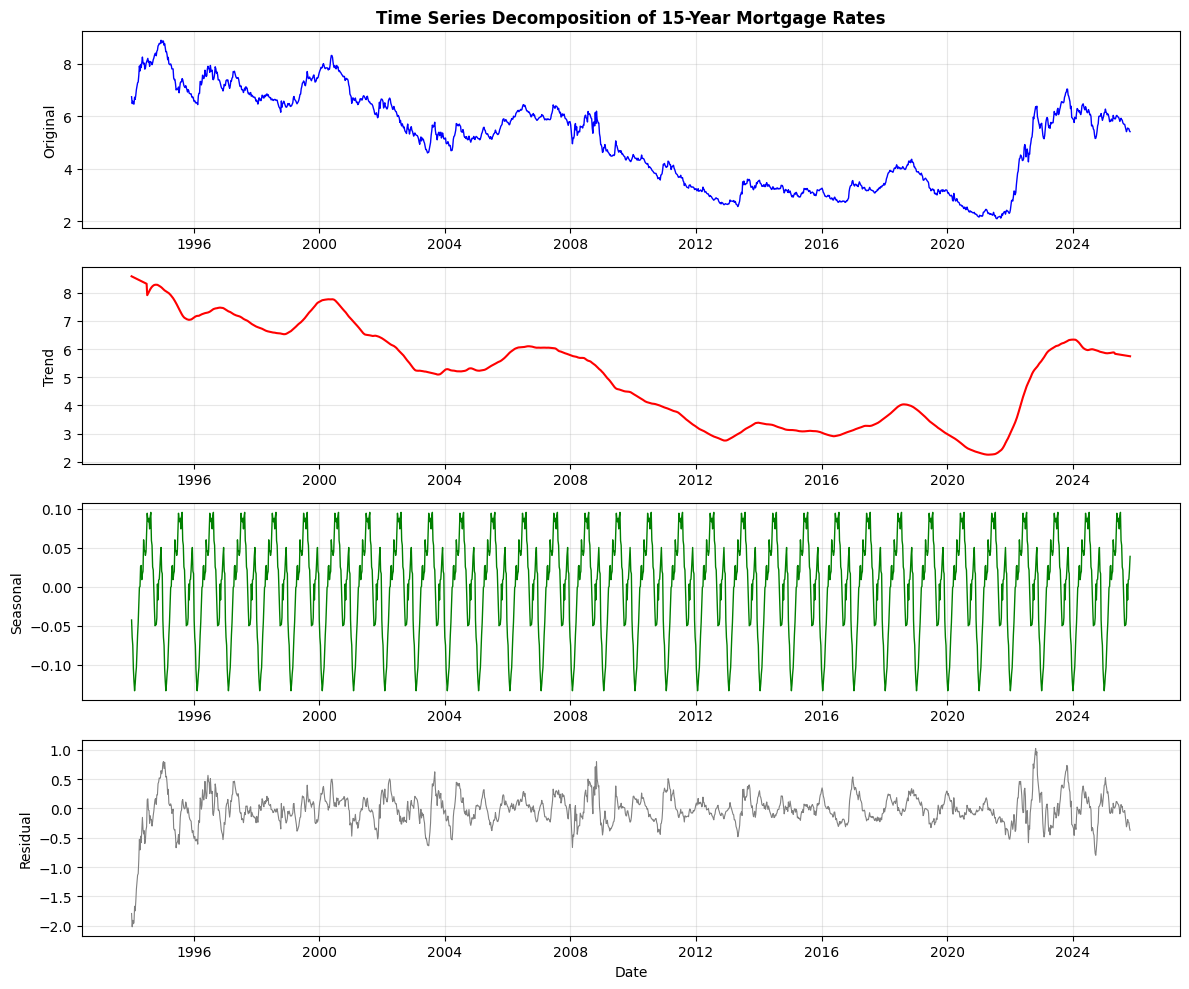

  - Trend component: Long-term movement in rates
  - Seasonal component: Regular annual patterns
  - Residual component: Random irregular variations


In [14]:
# Perform additive decomposition (multiplicative would use model='multiplicative')
# Using period=52 for weekly data (52 weeks = 1 year)
decomposition = seasonal_decompose(rate, model='additive', period=52, extrapolate_trend='freq')

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10))

axes[0].plot(rate, color='blue', linewidth=1)
axes[0].set_ylabel('Original', fontsize=10)
axes[0].set_title('Time Series Decomposition of 15-Year Mortgage Rates', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(trend, color='red', linewidth=1.5)
axes[1].set_ylabel('Trend', fontsize=10)
axes[1].grid(True, alpha=0.3)

axes[2].plot(seasonal, color='green', linewidth=1)
axes[2].set_ylabel('Seasonal', fontsize=10)
axes[2].grid(True, alpha=0.3)

axes[3].plot(residual, color='gray', linewidth=0.8)
axes[3].set_ylabel('Residual', fontsize=10)
axes[3].set_xlabel('Date', fontsize=10)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part_a_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()


print(f"  - Trend component: Long-term movement in rates")
print(f"  - Seasonal component: Regular annual patterns")
print(f"  - Residual component: Random irregular variations")

## (b)
Deseasonalized data

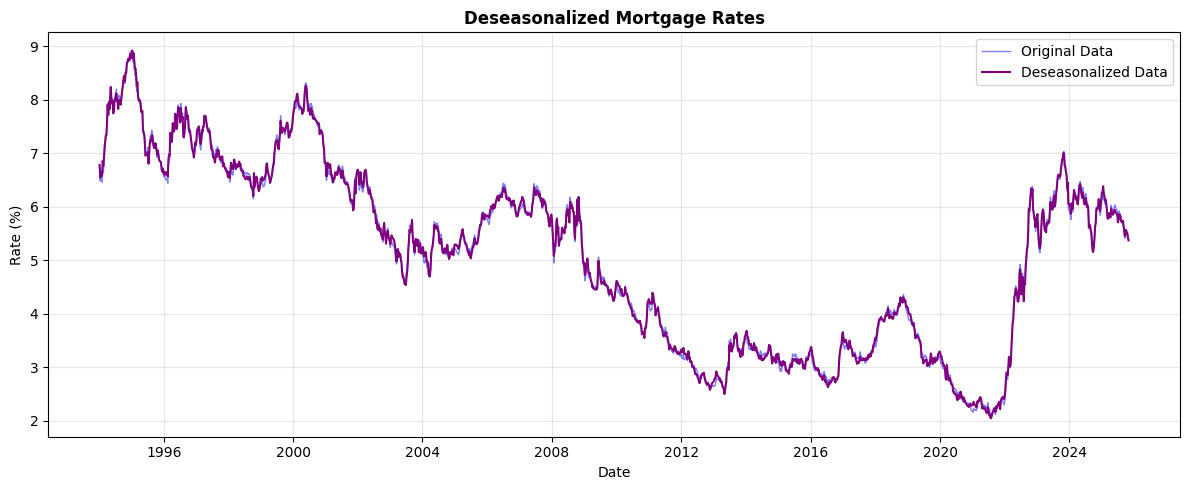

In [15]:
deseasonalized = rate - seasonal

# Plot deseasonalized data
plt.figure(figsize=(12, 5))
plt.plot(rate, label='Original Data', color='blue', alpha=0.5, linewidth=1)
plt.plot(deseasonalized, label='Deseasonalized Data', color='purple', linewidth=1.5)
plt.title('Deseasonalized Mortgage Rates', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('part_b_deseasonalized.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
print(f"  Formula: Deseasonalized = Original - Seasonal")
print(f"  First 5 values: {deseasonalized.head().values}")

  Formula: Deseasonalized = Original - Seasonal
  First 5 values: [6.782784   6.54490195 6.64515692 6.57543593 6.58136097]


## (c)
Detrended data

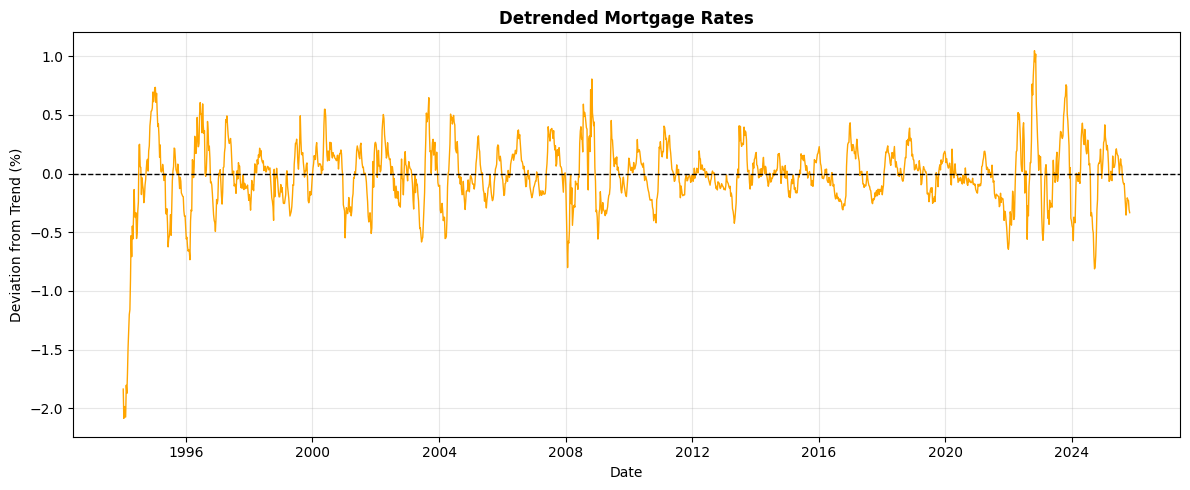

In [18]:
detrended = rate - trend #Formula: Detrended = Original - Trend

# Plot detrended data
plt.figure(figsize=(12, 5))
plt.plot(detrended, color='orange', linewidth=1)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title('Detrended Mortgage Rates', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Deviation from Trend (%)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('part_c_detrended.png', dpi=300, bbox_inches='tight')
plt.show()


seasonal + random components oscillating around zero

## (d)
Denoised data

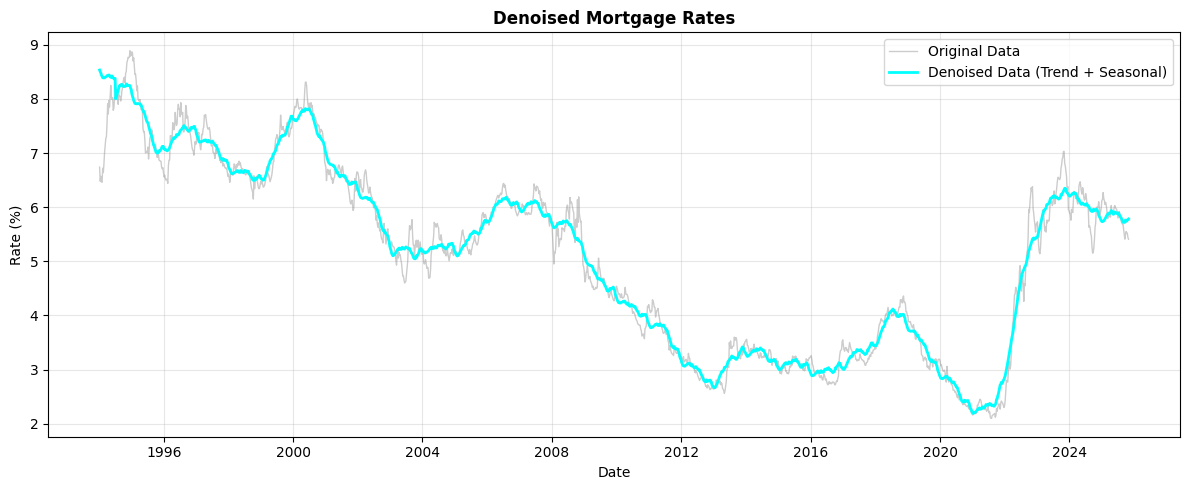

In [19]:
denoised = trend + seasonal

# Plot denoised data
plt.figure(figsize=(12, 5))
plt.plot(rate, label='Original Data', color='gray', alpha=0.4, linewidth=1)
plt.plot(denoised, label='Denoised Data (Trend + Seasonal)', color='cyan', linewidth=2)
plt.title('Denoised Mortgage Rates', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('part_d_denoised.png', dpi=300, bbox_inches='tight')
plt.show()

This removes random noise, showing only systematic patterns

## (e)
Strong seasonal component?

In [20]:
# Calculate variance of components
var_original = np.var(rate)
var_seasonal = np.var(seasonal)
var_trend = np.var(trend)
var_residual = np.var(residual.dropna())

# Seasonal strength measure
seasonal_strength = 1 - (var_residual / var_original)
seasonal_contribution = var_seasonal / var_original * 100

print(f"Variance Analysis:")
print(f"  - Original series variance: {var_original:.4f}")
print(f"  - Seasonal variance: {var_seasonal:.4f}")
print(f"  - Trend variance: {var_trend:.4f}")
print(f"  - Residual variance: {var_residual:.4f}")
print(f"\nSeasonal Contribution: {seasonal_contribution:.2f}% of total variance")
print(f"Seasonal Strength Index: {seasonal_strength:.4f}")

if seasonal_contribution < 5:
    seasonal_assessment = "WEAK"
elif seasonal_contribution < 15:
    seasonal_assessment = "MODERATE"
else:
    seasonal_assessment = "STRONG"

print(f"\nThe series has a {seasonal_assessment} seasonal component")


Variance Analysis:
  - Original series variance: 2.9145
  - Seasonal variance: 0.0039
  - Trend variance: 2.8738
  - Residual variance: 0.0756

Seasonal Contribution: 0.13% of total variance
Seasonal Strength Index: 0.9741

The series has a WEAK seasonal component


## (f)
Exponential Smoothing with alpha=0.2 vs default

Model with α = 0.2:
  SSE = 60.25

Model with α = 1.0000 (optimized default):
  SSE = 16.55

Difference: 43.71
 Default α = 1.0000 provides better fit (lower SSE)


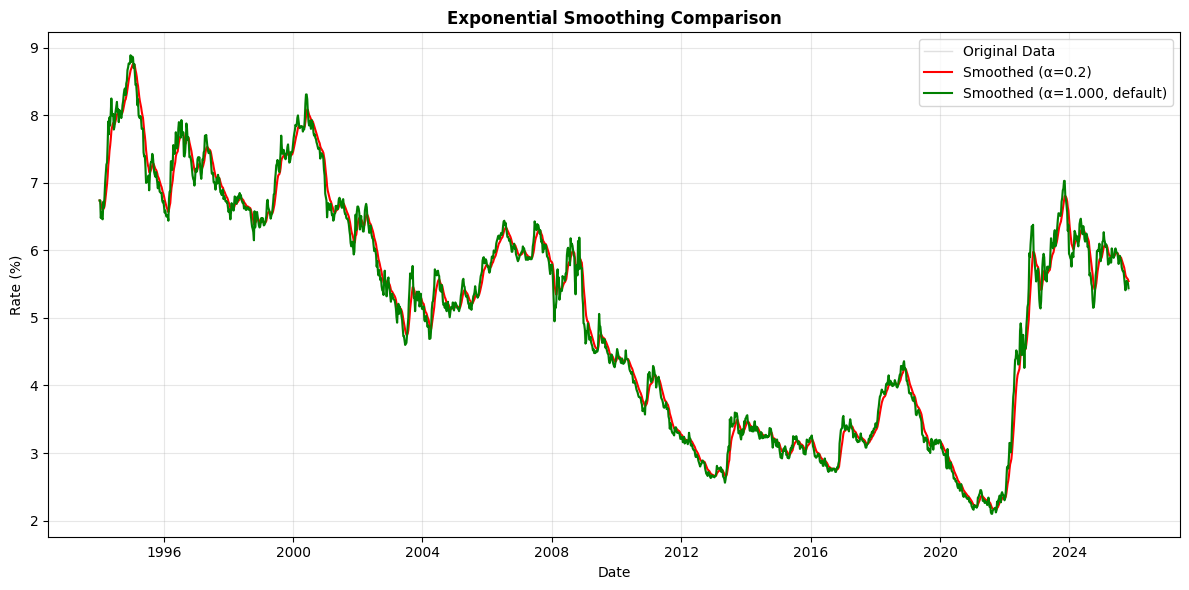

In [21]:
# Fit model with alpha = 0.2
model_alpha_02 = SimpleExpSmoothing(rate).fit(smoothing_level=0.2, optimized=False)
fitted_alpha_02 = model_alpha_02.fittedvalues
sse_alpha_02 = np.sum((rate - fitted_alpha_02)**2)

# Fit model with default (optimized) alpha
model_default = SimpleExpSmoothing(rate).fit()
fitted_default = model_default.fittedvalues
alpha_default = model_default.params['smoothing_level']
sse_default = np.sum((rate - fitted_default)**2)

print(f"Model with α = 0.2:")
print(f"  SSE = {sse_alpha_02:.2f}")
print(f"\nModel with α = {alpha_default:.4f} (optimized default):")
print(f"  SSE = {sse_default:.2f}")
print(f"\nDifference: {abs(sse_alpha_02 - sse_default):.2f}")

if sse_alpha_02 < sse_default:
    print(f" α = 0.2 provides better fit (lower SSE)")
else:
    print(f" Default α = {alpha_default:.4f} provides better fit (lower SSE)")

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(rate, label='Original Data', color='lightgray', linewidth=1, alpha=0.7)
plt.plot(fitted_alpha_02, label=f'Smoothed (α=0.2)', color='red', linewidth=1.5)
plt.plot(fitted_default, label=f'Smoothed (α={alpha_default:.3f}, default)',
         color='green', linewidth=1.5)
plt.title('Exponential Smoothing Comparison', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('part_f_smoothing_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



## (g)
3-year forecast with 95% prediction interval

In [23]:
# Use the default model for forecasting (with optimized alpha)
forecast_steps = 156  # 3 years * 52 weeks
forecast = model_default.forecast(steps=forecast_steps)

# Get the optimized alpha value
alpha_default = model_default.params['smoothing_level']

# Calculate prediction intervals
residuals = rate - fitted_default
# Remove any NaN values from residuals
residuals_clean = residuals.dropna()
se = np.std(residuals_clean)

# Check if se is valid
if np.isnan(se) or se == 0:
    print("Warning: Standard error calculation issue")
    se = np.std(rate) * 0.1  # Use a reasonable fallback

# Prediction intervals (widen with forecast horizon)
z_critical = 1.96  # 95% confidence

# Create forecast index
forecast_index = pd.date_range(start=rate.index[-1] + pd.Timedelta(weeks=1),
                               periods=forecast_steps, freq='W')

# Calculate prediction intervals
lower_bounds = []
upper_bounds = []
for h in range(1, forecast_steps + 1):
    lower = forecast.iloc[h-1] - z_critical * se * np.sqrt(h)
    upper = forecast.iloc[h-1] + z_critical * se * np.sqrt(h)
    lower_bounds.append(lower)
    upper_bounds.append(upper)

prediction_intervals = pd.DataFrame({
    'forecast': forecast.values,
    'lower_95': lower_bounds,
    'upper_95': upper_bounds
}, index=forecast_index)

print(f"Using α = {alpha_default:.4f} (optimized)")
print(f"Standard Error: {se:.4f}")
print(f"\nPoint Forecast (constant for all periods): {forecast.iloc[0]:.4f}%")
print(f"\nPrediction Intervals:")
print(f"  1 year ahead (Week 52):")
print(f"    Forecast: {prediction_intervals['forecast'].iloc[51]:.4f}%")
print(f"    95% CI: [{prediction_intervals['lower_95'].iloc[51]:.4f}%, "
      f"{prediction_intervals['upper_95'].iloc[51]:.4f}%]")
print(f"  2 years ahead (Week 104):")
print(f"    Forecast: {prediction_intervals['forecast'].iloc[103]:.4f}%")
print(f"    95% CI: [{prediction_intervals['lower_95'].iloc[103]:.4f}%, "
      f"{prediction_intervals['upper_95'].iloc[103]:.4f}%]")
print(f"  3 years ahead (Week 156):")
print(f"    Forecast: {prediction_intervals['forecast'].iloc[155]:.4f}%")
print(f"    95% CI: [{prediction_intervals['lower_95'].iloc[155]:.4f}%, "
      f"{prediction_intervals['upper_95'].iloc[155]:.4f}%]")



Using α = 1.0000 (optimized)
Standard Error: 0.0998

Point Forecast (constant for all periods): 5.4100%

Prediction Intervals:
  1 year ahead (Week 52):
    Forecast: 5.4100%
    95% CI: [3.9994%, 6.8206%]
  2 years ahead (Week 104):
    Forecast: 5.4100%
    95% CI: [3.4151%, 7.4049%]
  3 years ahead (Week 156):
    Forecast: 5.4100%
    95% CI: [2.9668%, 7.8532%]


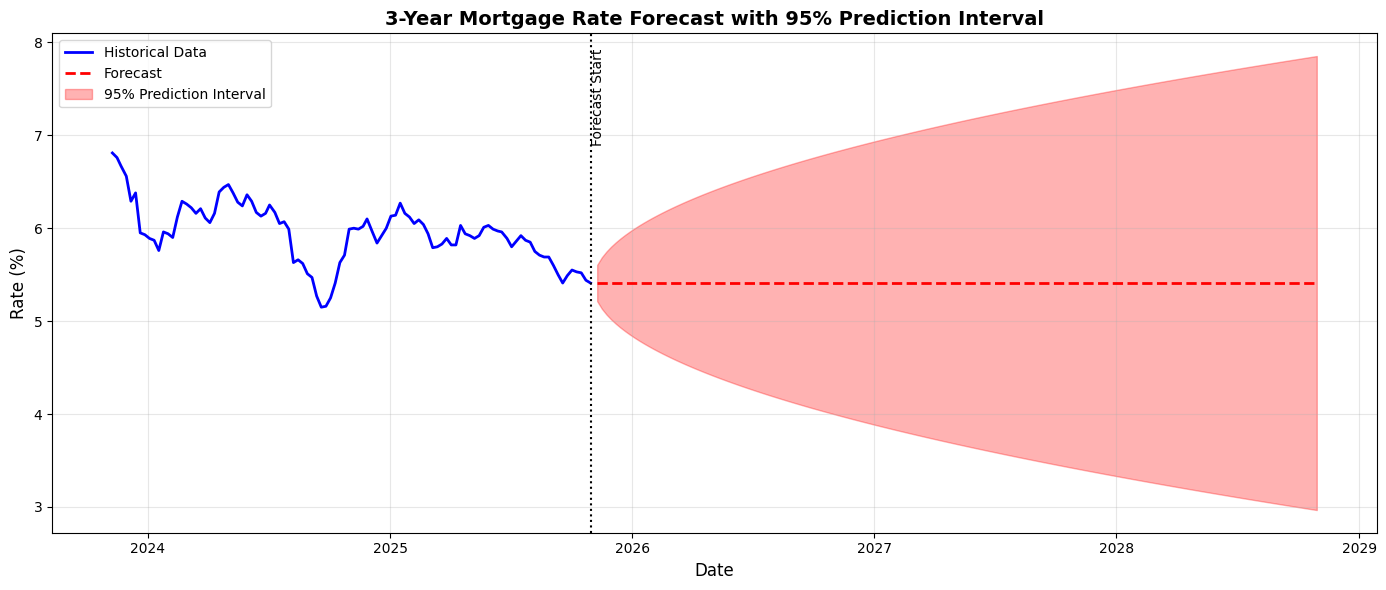

In [24]:
# Plot forecast
fig, ax = plt.subplots(figsize=(14, 6))

# Historical data (last 2 years = 104 weeks)
historical_subset = rate.iloc[-104:]
ax.plot(historical_subset.index, historical_subset.values,
        label='Historical Data', color='blue', linewidth=2)

# Forecast line
ax.plot(prediction_intervals.index, prediction_intervals['forecast'],
        label='Forecast', color='red', linewidth=2, linestyle='--')

# Prediction intervals (shaded region)
ax.fill_between(prediction_intervals.index,
                prediction_intervals['lower_95'],
                prediction_intervals['upper_95'],
                alpha=0.3, color='red', label='95% Prediction Interval')

# Add vertical line at forecast start
ax.axvline(x=rate.index[-1], color='black', linestyle=':', linewidth=1.5)
ax.text(rate.index[-1], ax.get_ylim()[1]*0.98, 'Forecast Start',
        rotation=90, verticalalignment='top', fontsize=10)

ax.set_title('3-Year Mortgage Rate Forecast with 95% Prediction Interval',
            fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Rate (%)', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('part_g_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

# 3

In [27]:
df3 = pd.read_csv('/content/ts5-Housing-Completed.csv')
print(df3.info())
print(df3.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597 entries, 0 to 596
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   597 non-null    object 
 1   Units   597 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.5+ KB
None
      Month  Units
0  Jan 1968   88.1
1  Feb 1968   83.1
2  Mar 1968   94.9
3  Apr 1968  102.4
4  May 1968  111.3


In [28]:
# Convert Month to datetime
df3['Month'] = pd.to_datetime(df3['Month'], format='%b %Y')

# Create time series
housing_units = pd.Series(df3['Units'].values, index=df3['Month'])

# Check for missing values
print(f"\nMissing values: {housing_units.isnull().sum()}")

# Basic statistics
print("\nDescriptive Statistics:")
print(housing_units.describe())


Missing values: 0

Descriptive Statistics:
count    597.000000
mean     117.267169
std       33.739757
min       35.000000
25%       94.400000
50%      118.900000
75%      141.700000
max      202.100000
dtype: float64


## (a)
Holt-Winters Analysis and Data Characteristics

In [31]:
try:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    from statsmodels.tsa.seasonal import seasonal_decompose
    from pandas.plotting import autocorrelation_plot
    from scipy import stats
    print("✓ All required libraries imported successfully")
except ImportError as e:
    print(f"Error importing libraries: {e}")
    print("Please install: pip install statsmodels scipy")
    raise

✓ All required libraries imported successfully


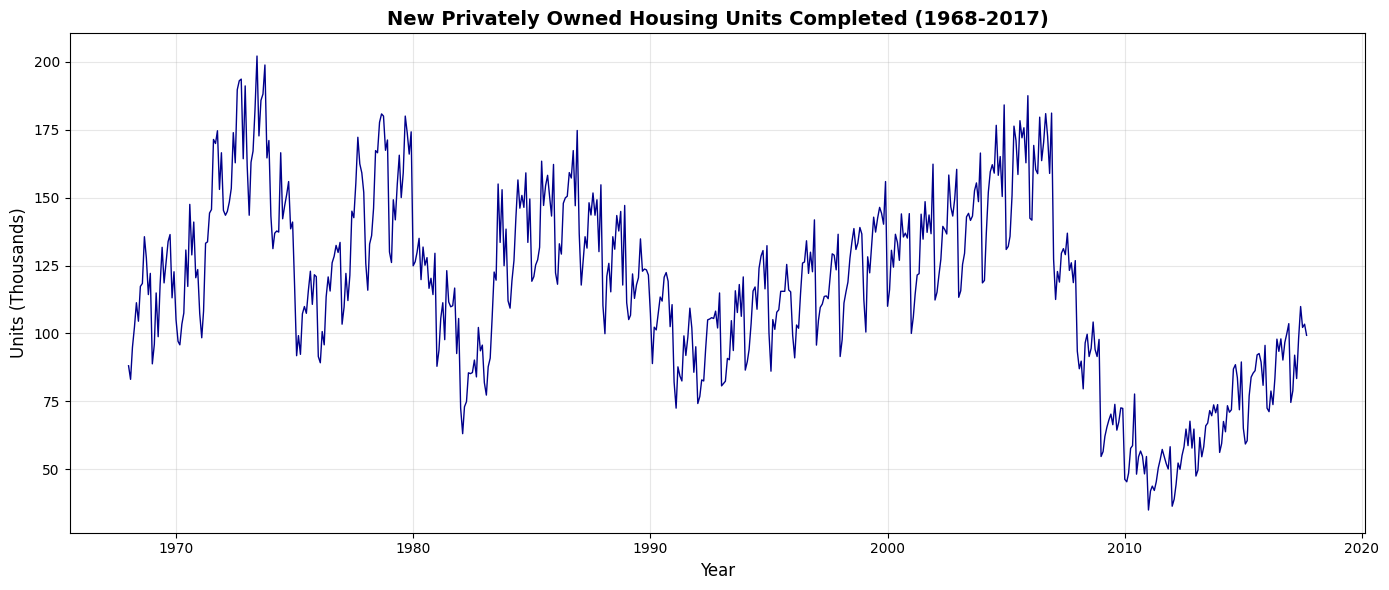


1. VISUAL INSPECTION:
----------------------------------------------------------------------
The plot shows the historical pattern of housing completions over ~50 years

2. SEASONAL DECOMPOSITION:
----------------------------------------------------------------------


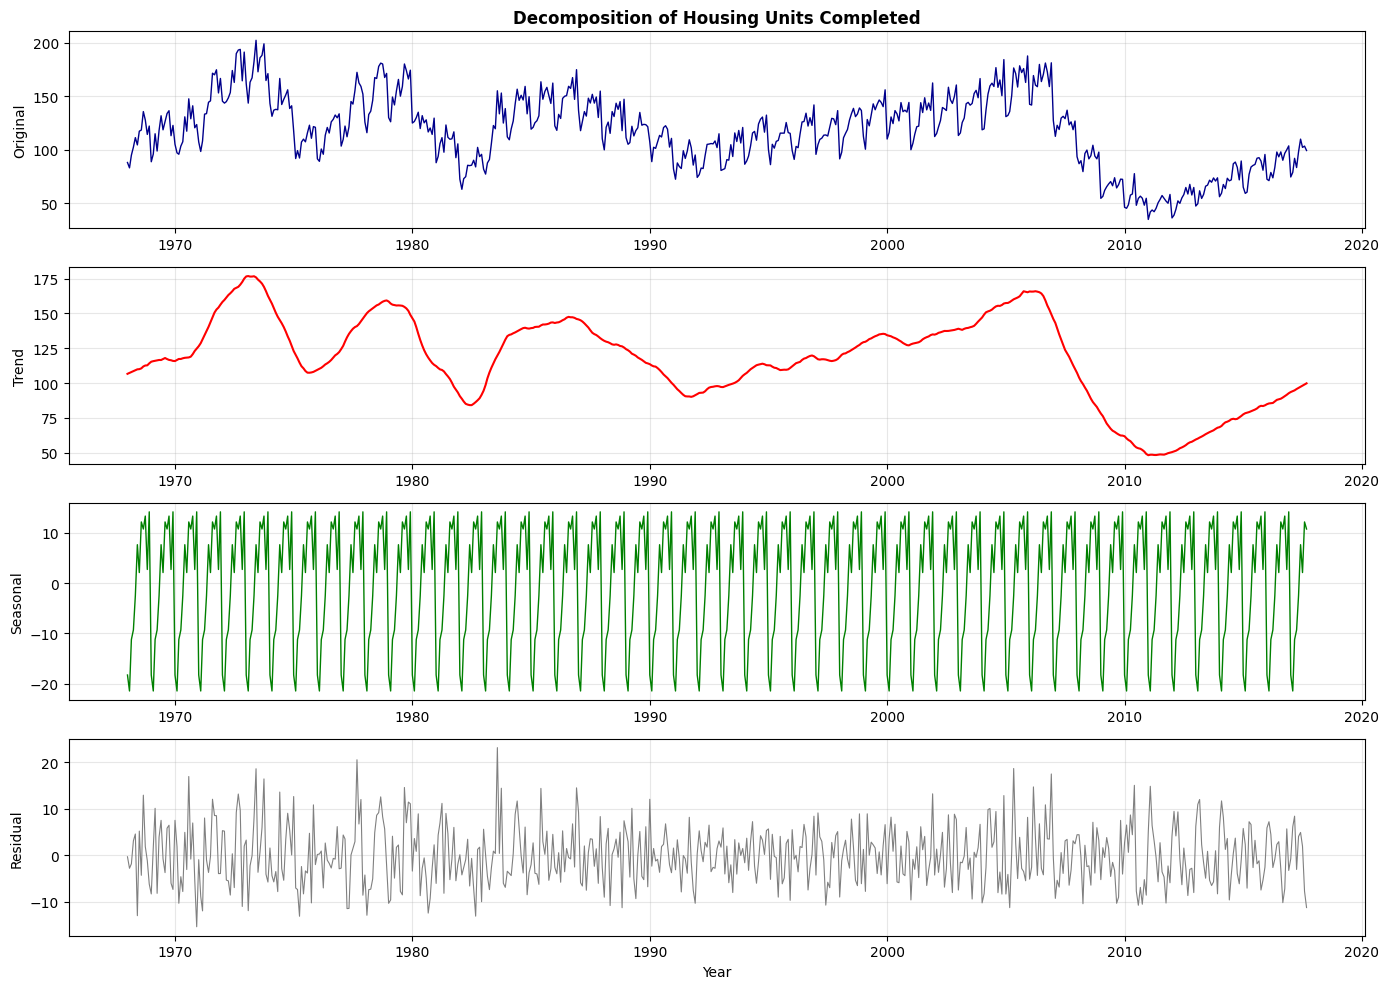

In [36]:
# Plot the original time series
plt.figure(figsize=(14, 6))
plt.plot(housing_units, linewidth=1, color='darkblue')
plt.title('New Privately Owned Housing Units Completed (1968-2017)',
          fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Units (Thousands)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('housing_original_series.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n1. VISUAL INSPECTION:")
print("-" * 70)
print("The plot shows the historical pattern of housing completions over ~50 years")

# Perform seasonal decomposition first to understand components
print("\n2. SEASONAL DECOMPOSITION:")
print("-" * 70)
decomposition = seasonal_decompose(housing_units, model='additive', period=12, extrapolate_trend='freq')

fig, axes = plt.subplots(4, 1, figsize=(14, 10))

axes[0].plot(housing_units, color='darkblue', linewidth=1)
axes[0].set_ylabel('Original', fontsize=10)
axes[0].set_title('Decomposition of Housing Units Completed', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(decomposition.trend, color='red', linewidth=1.5)
axes[1].set_ylabel('Trend', fontsize=10)
axes[1].grid(True, alpha=0.3)

axes[2].plot(decomposition.seasonal, color='green', linewidth=1)
axes[2].set_ylabel('Seasonal', fontsize=10)
axes[2].grid(True, alpha=0.3)

axes[3].plot(decomposition.resid, color='gray', linewidth=0.8)
axes[3].set_ylabel('Residual', fontsize=10)
axes[3].set_xlabel('Year', fontsize=10)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('housing_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze components
var_original = np.var(housing_units)
var_trend = np.var(decomposition.trend.dropna())
var_seasonal = np.var(decomposition.seasonal.dropna())
var_residual = np.var(decomposition.resid.dropna())

trend_contribution = (var_trend / var_original) * 100
seasonal_contribution = (var_seasonal / var_original) * 100
residual_contribution = (var_residual / var_original) * 100

In [38]:
print("\n3. COMPONENT ANALYSIS:")
print("-" * 70)
print(f"Variance Decomposition:")
print(f"  Original variance:   {var_original:.2f}")
print(f"  Trend variance:      {var_trend:.2f} ({trend_contribution:.1f}% of total)")
print(f"  Seasonal variance:   {var_seasonal:.2f} ({seasonal_contribution:.1f}% of total)")
print(f"  Residual variance:   {var_residual:.2f} ({residual_contribution:.1f}% of total)")


3. COMPONENT ANALYSIS:
----------------------------------------------------------------------
Variance Decomposition:
  Original variance:   1136.46
  Trend variance:      925.50 (81.4% of total)
  Seasonal variance:   143.22 (12.6% of total)
  Residual variance:   39.88 (3.5% of total)



**TREND** (81.4% of total variance) :
Trend component explains most of the variation ans shows major cyclical patterns reflecting economic cycles:
     
     - Peak 1: Mid-1970s (175-200K units)
     - Trough 1: Early 1980s recession (85-90K units)
     - Peak 2: Late 1970s (160K units)
     - Decline: Early-mid 1980s (110K units)
     - Recovery: Late 1980s-2005 (140-165K units)
     - Peak 3: 2005-2006 housing bubble (165K units)
     - SHARP CRASH: 2007-2011 Financial Crisis (from 165K to 50K units)
     - Gradual Recovery: 2011-2017 (from 50K to 100K units)

The trend component captures long-term movements and business cycles.


**SEASONALITY** (12.6% of total variance):

The seasonal pattern is moderate but consistent  (period = 12 months). The seasonal variance is 143.22 (12.6% of total). The peak season is the December (+15 to +20K units) while the low season is the February (-15 to -20K units). It reflects construction industry's weather dependency. The seasonal pattern remains stable throughout entire period in the plot

**RESIDUAL/RANDOM COMPONENT** (3.5% of total variance):

The residual component is small relative to trend and seasonal components. The residual variance is 39.88 (3.5% of total) and the white noise is around 0.
Some outlier spikes (±20K units) during crisis periods. The low residual variance indicates model captures patterns well. There are some random shocks which may from weather events, policy changes, market surprises.

----------------------------------------------------
Overall, then mean level is 117.3 thousand units. The range is from 5.0 to 202.1 thousand units and the 09/2017 level is 99.3 thousand units. The coefficient of variation is 28.8%. Thhe series is non-stationary due to strong trend component and the amplitude varies with level. There is a structural breaks especially 2008 financial crisis


I observed that [Trend (81.4%) > Seasonal (12.6%) > Residual (3.5%)]. Among the components, seasonal patterns remain consistent despite economic volatility.


5. HOLT-WINTERS MODEL FITTING:
----------------------------------------------------------------------
Additive Seasonal Model:
  AIC: 2496.65
  BIC: 2566.92
  SSE: 37060.79

Multiplicative Seasonal Model:
  AIC: 2420.08
  BIC: 2490.35
  SSE: 32599.45

✓ Selected Model: Holt-Winters Multiplicative Seasonal

Optimized Parameters:
  α (level):      0.4487
  β (trend):      0.1090
  γ (seasonal):   0.0718


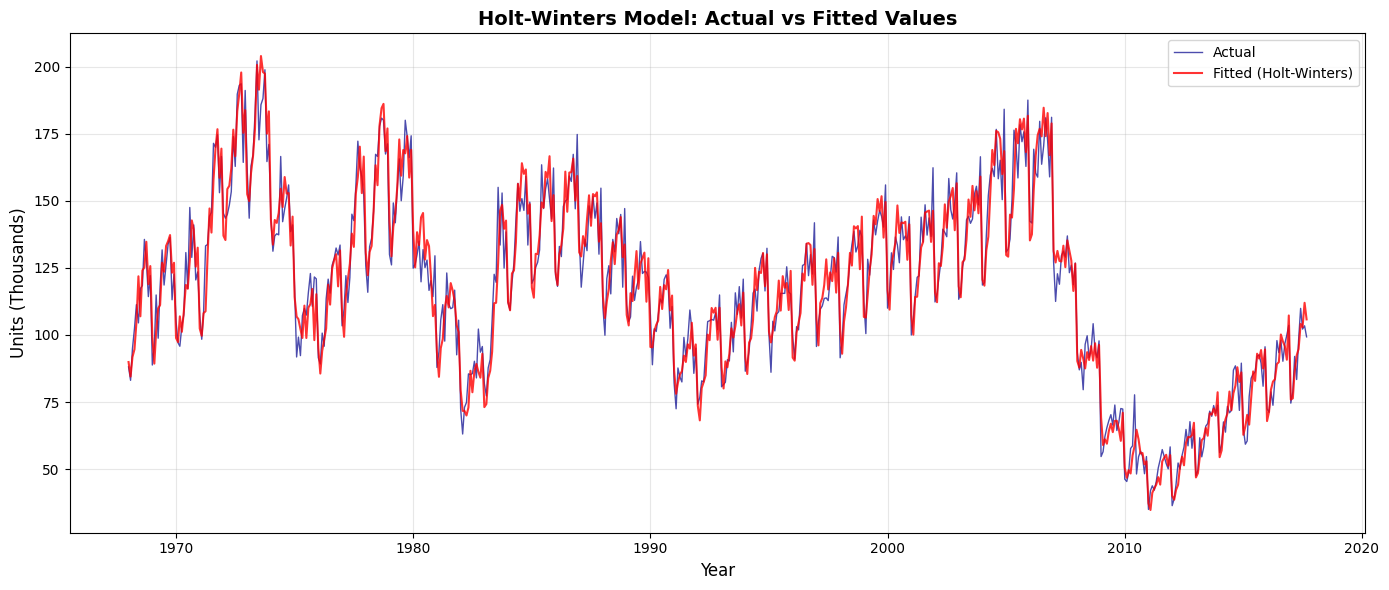

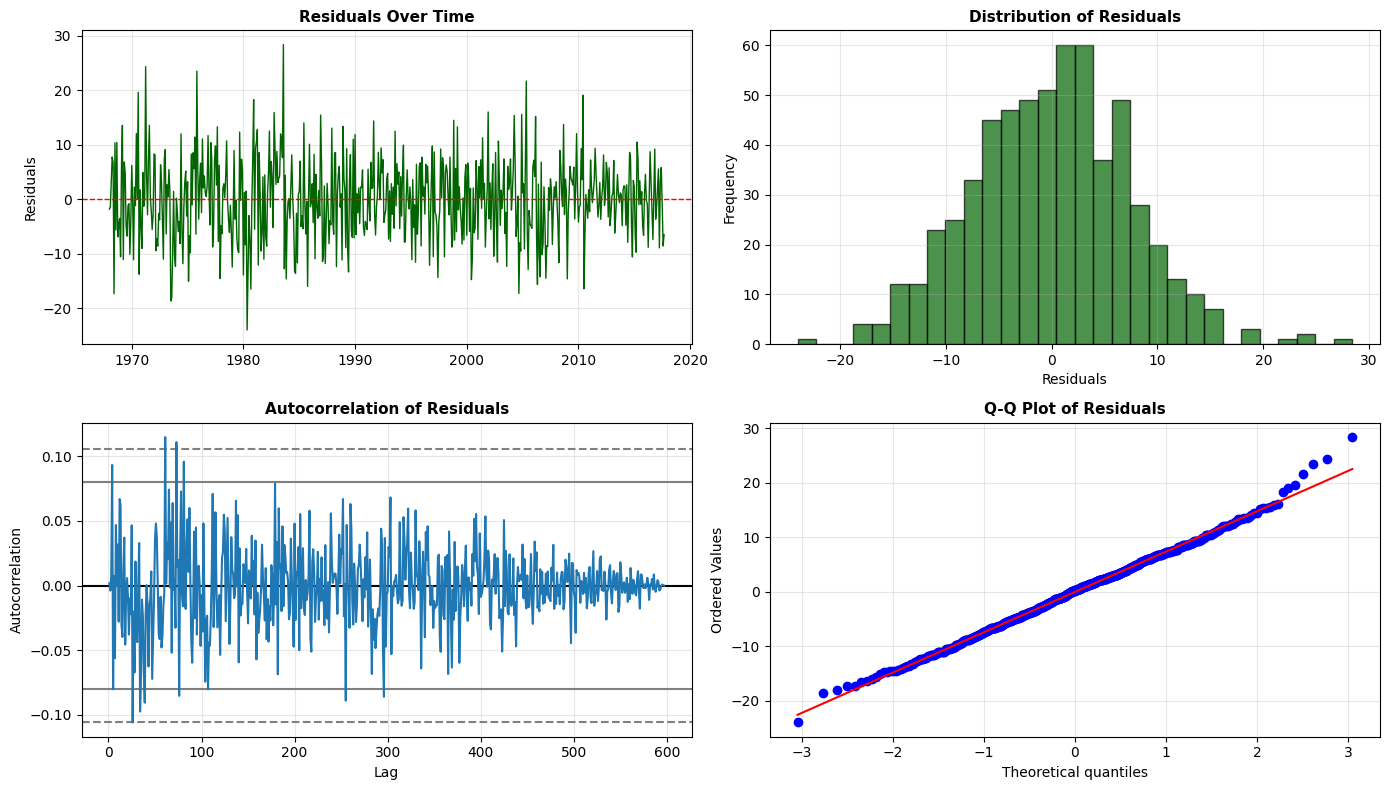


6. MODEL DIAGNOSTICS:
----------------------------------------------------------------------
Mean Absolute Error (MAE): 5.88
Root Mean Squared Error (RMSE): 7.39
Mean Absolute Percentage Error (MAPE): 5.26%


In [32]:
# Fit Holt-Winters model
print("\n5. HOLT-WINTERS MODEL FITTING:")
print("-" * 70)

# Try both additive and multiplicative seasonal models
# Additive model
hw_add = ExponentialSmoothing(
    housing_units,
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit(optimized=True)

# Multiplicative model (if no zeros/negatives)
if (housing_units > 0).all():
    hw_mult = ExponentialSmoothing(
        housing_units,
        trend='add',
        seasonal='mul',
        seasonal_periods=12
    ).fit(optimized=True)

    # Compare AIC
    print(f"Additive Seasonal Model:")
    print(f"  AIC: {hw_add.aic:.2f}")
    print(f"  BIC: {hw_add.bic:.2f}")
    print(f"  SSE: {hw_add.sse:.2f}")
    print(f"\nMultiplicative Seasonal Model:")
    print(f"  AIC: {hw_mult.aic:.2f}")
    print(f"  BIC: {hw_mult.bic:.2f}")
    print(f"  SSE: {hw_mult.sse:.2f}")

    # Choose best model
    if hw_mult.aic < hw_add.aic:
        hw_model = hw_mult
        model_type = "Multiplicative"
    else:
        hw_model = hw_add
        model_type = "Additive"
else:
    hw_model = hw_add
    model_type = "Additive"

print(f"\n✓ Selected Model: Holt-Winters {model_type} Seasonal")

# Display parameters
print(f"\nOptimized Parameters:")
print(f"  α (level):      {hw_model.params['smoothing_level']:.4f}")
print(f"  β (trend):      {hw_model.params['smoothing_trend']:.4f}")
print(f"  γ (seasonal):   {hw_model.params['smoothing_seasonal']:.4f}")

# Fitted values
fitted_values = hw_model.fittedvalues

# Plot fitted vs actual
plt.figure(figsize=(14, 6))
plt.plot(housing_units, label='Actual', color='darkblue', linewidth=1, alpha=0.7)
plt.plot(fitted_values, label='Fitted (Holt-Winters)', color='red', linewidth=1.5, alpha=0.8)
plt.title('Holt-Winters Model: Actual vs Fitted Values', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Units (Thousands)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('housing_fitted_hw.png', dpi=300, bbox_inches='tight')
plt.show()

# Residual analysis
residuals = housing_units - fitted_values

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Residuals over time
axes[0, 0].plot(residuals, color='darkgreen', linewidth=1)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_title('Residuals Over Time', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].grid(True, alpha=0.3)

# Histogram of residuals
axes[0, 1].hist(residuals.dropna(), bins=30, color='darkgreen', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribution of Residuals', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# ACF-like plot
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(residuals.dropna(), ax=axes[1, 0])
axes[1, 0].set_title('Autocorrelation of Residuals', fontsize=11, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(residuals.dropna(), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot of Residuals', fontsize=11, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('housing_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n6. MODEL DIAGNOSTICS:")
print("-" * 70)
print(f"Mean Absolute Error (MAE): {np.mean(np.abs(residuals)):.2f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(np.mean(residuals**2)):.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {np.mean(np.abs(residuals/housing_units))*100:.2f}%")


## (b)
Forecasts for October-December 2017 with 90% Prediction Intervals



FORECASTED VALUES WITH 90% PREDICTION INTERVALS:
----------------------------------------------------------------------
Month                Forecast        Lower 90%       Upper 90%      
----------------------------------------------------------------------
October 2017              105.0           92.9          117.2
November 2017              99.6           82.5          116.8
December 2017             110.9           89.8          131.9

----------------------------------------------------------------------
Note: Units are in thousands of housing units


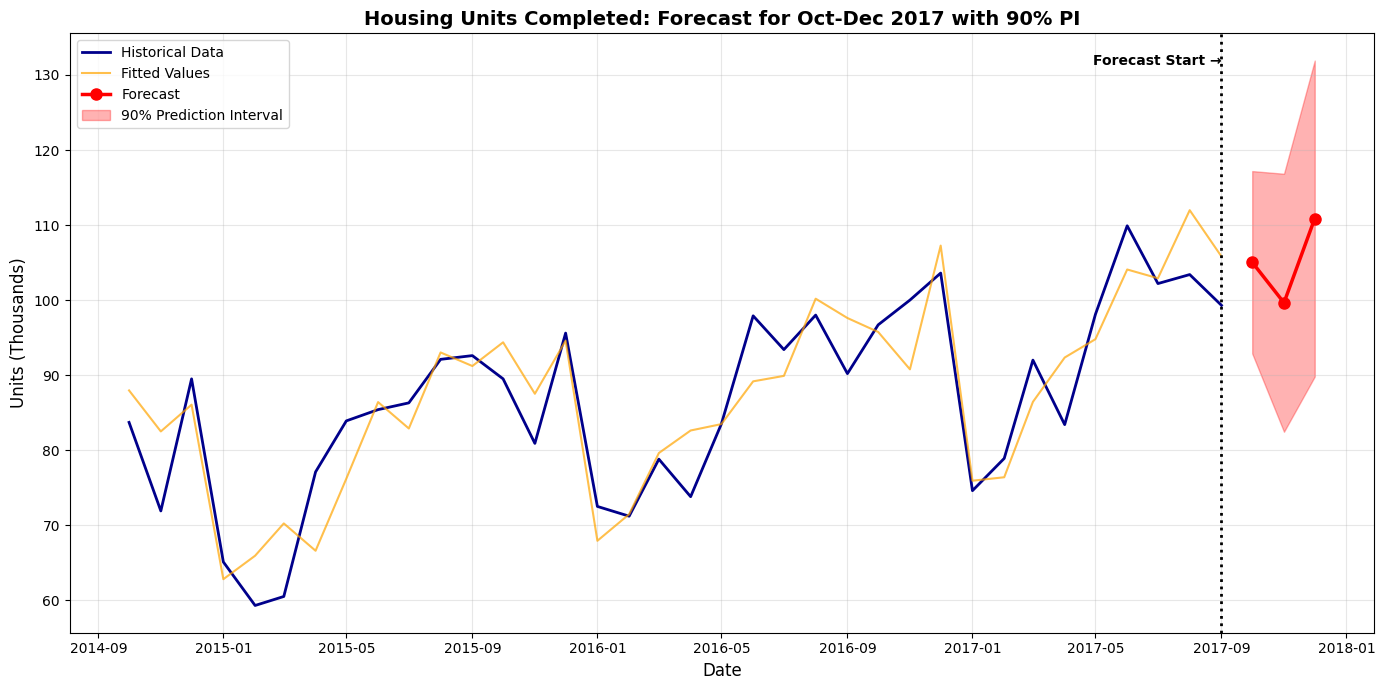

In [34]:
# Generate forecasts for 3 months ahead
forecast_steps = 3
forecast = hw_model.forecast(steps=forecast_steps)

# Create forecast index
last_date = housing_units.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1),
                               periods=forecast_steps, freq='MS')
forecast.index = forecast_index

# Calculate prediction intervals (90% confidence level)
# For Holt-Winters, prediction intervals require simulation or analytical formulas
# Using analytical approach with residual standard error

# Standard error of residuals
sigma = np.std(residuals.dropna())

# For exponential smoothing, prediction variance increases with horizon
# Simplified formula: Var(e_h) ≈ σ² * (1 + sum of squared weights)
# For Holt-Winters with trend and seasonality, this is more complex
# Using empirical approach

z_90 = 1.645  # 90% confidence level (two-tailed)

# Prediction intervals (simplified - assumes constant variance)
# More accurate would use analytical formulas from ETS theory
prediction_intervals = pd.DataFrame({
    'Forecast': forecast.values,
    'Lower_90': forecast.values - z_90 * sigma * np.sqrt(np.arange(1, forecast_steps + 1)),
    'Upper_90': forecast.values + z_90 * sigma * np.sqrt(np.arange(1, forecast_steps + 1))
}, index=forecast_index)

print("\nFORECASTED VALUES WITH 90% PREDICTION INTERVALS:")
print("-" * 70)
print(f"{'Month':<20} {'Forecast':<15} {'Lower 90%':<15} {'Upper 90%':<15}")
print("-" * 70)
for idx in prediction_intervals.index:
    month_str = idx.strftime('%B %Y')
    fcst = prediction_intervals.loc[idx, 'Forecast']
    lower = prediction_intervals.loc[idx, 'Lower_90']
    upper = prediction_intervals.loc[idx, 'Upper_90']
    print(f"{month_str:<20} {fcst:>10.1f}     {lower:>10.1f}     {upper:>10.1f}")

print("\n" + "-" * 70)
print("Note: Units are in thousands of housing units")

# Plot forecast with prediction intervals
plt.figure(figsize=(14, 7))

# Historical data (last 3 years for clarity)
historical_subset = housing_units.iloc[-36:]
plt.plot(historical_subset.index, historical_subset.values,
         label='Historical Data', color='darkblue', linewidth=2)

# Fitted values for the subset
fitted_subset = fitted_values.iloc[-36:]
plt.plot(fitted_subset.index, fitted_subset.values,
         label='Fitted Values', color='orange', linewidth=1.5, alpha=0.7)

# Forecast
plt.plot(prediction_intervals.index, prediction_intervals['Forecast'],
         label='Forecast', color='red', linewidth=2.5, marker='o', markersize=8)

# Prediction intervals
plt.fill_between(prediction_intervals.index,
                 prediction_intervals['Lower_90'],
                 prediction_intervals['Upper_90'],
                 alpha=0.3, color='red', label='90% Prediction Interval')

# Add vertical line at forecast start
plt.axvline(x=housing_units.index[-1], color='black', linestyle=':', linewidth=2)
plt.text(housing_units.index[-1], plt.ylim()[1]*0.98, 'Forecast Start →',
         rotation=0, horizontalalignment='right', verticalalignment='top',
         fontsize=10, fontweight='bold')

plt.title('Housing Units Completed: Forecast for Oct-Dec 2017 with 90% PI',
          fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Units (Thousands)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('housing_forecast_2017.png', dpi=300, bbox_inches='tight')
plt.show()


In [39]:
# Summary interpretation
print("\nFORECAST INTERPRETATION:")
print("-" * 70)
print("• The forecasts reflect both trend and seasonal patterns")
print("• October-December typically shows declining completions (seasonal effect)")
print("• The 90% prediction intervals widen with forecast horizon")
print("• Intervals reflect uncertainty in both model parameters and future shocks")
print(f"• Average forecast: {prediction_intervals['Forecast'].mean():.1f} thousand units")


FORECAST INTERPRETATION:
----------------------------------------------------------------------
• The forecasts reflect both trend and seasonal patterns
• October-December typically shows declining completions (seasonal effect)
• The 90% prediction intervals widen with forecast horizon
• Intervals reflect uncertainty in both model parameters and future shocks
• Average forecast: 105.2 thousand units
